In [2]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set font size for matplotlib
plt.rcParams['font.size'] = 16

In [3]:
# Path to the dataset
DATASET_PATH = "/Users/hwiyoonkim/Desktop/fashion-dataset/"

# Read CSV files containing image and style data
img_df = pd.read_csv('/Users/hwiyoonkim/Desktop/fashion-dataset/images.csv')
styles_df = pd.read_csv('/Users/hwiyoonkim/Desktop/fashion-dataset/styles.csv', on_bad_lines='skip')

In [4]:
# Display the first few rows of the image dataframe
img_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [5]:
# Attempt to read the styles.csv file with error handling
try:
    df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000)
except pd.errors.ParserError:
    # Handle parser error here, or simply skip problematic lines
    df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)

# Add a new column 'image' by concatenating 'id' with '.jpg'
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)

# Display the first 20 rows of the DataFrame
df.head(20)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


<Axes: ylabel='articleType'>

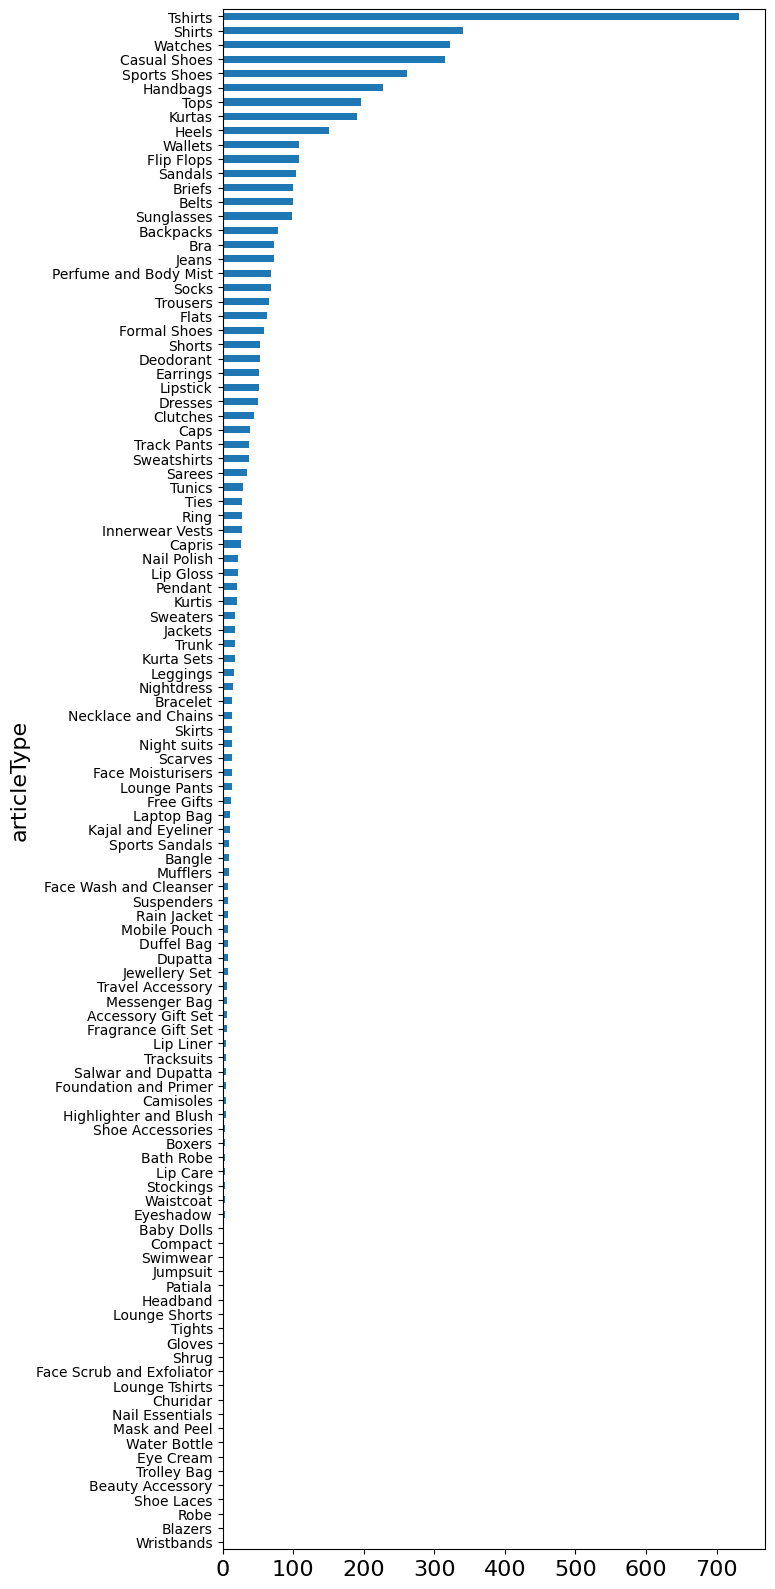

In [6]:
# Plot a bar chart showing the distribution of article types
plt.figure(figsize=(7,20))
plt.tick_params(axis='y', labelsize=10)
df.articleType.value_counts().sort_values().plot(kind='barh')

In [7]:
# Display the first few rows of the styles DataFrame
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
# Add a new column 'filename' by concatenating 'id' with '.jpg'
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

In [9]:
#display
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [10]:
# Check if the image files are present in the directory
img_path = '/Users/hwiyoonkim/Desktop/fashion-dataset/images/'
img_files = os.listdir(img_path)

In [11]:
styles_df['present'] = styles_df['filename'].apply(lambda x:x in img_files)

In [12]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [13]:
styles_df = styles_df.sample(10000)

In [14]:
# Define the image size for resizing
img_size = 224

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1/255.)

# Generate batches of images and labels from the DataFrame
generator = datagen.flow_from_dataframe(dataframe = styles_df,
                                       directory = img_path,
                                       target_size = (img_size,img_size),
                                       x_col = 'filename',
                                       class_mode = None,
                                       batch_size = 32,
                                       shuffle = False,
                                       classes= None)

Found 10000 validated image filenames.


In [15]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(include_top=False, input_shape= (img_size,img_size,3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Define input layer    
input_layer = Input(shape=(img_size,img_size,3))
# Pass input through the base model
x= base_model(input_layer)
output= GlobalAveragePooling2D()(x)

# Define the embeddings model
embeddings = Model(inputs = input_layer, outputs= output)
embeddings.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Generate embeddings for all images
X = embeddings.predict(generator, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 951s 3s/step


In [20]:
# Function to read and preprocess images
def read_img(image_path):
    image = load_img(os.path.join(img_path,image_path),target_size=(img_size,img_size,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [21]:
# Import necessary libraries
import random
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# Extract labels
y = styles_df['id']

In [23]:
# Initialize KNeighborsClassifier
nearest_neighbors = KNeighborsClassifier(n_neighbors = 7)
# Fit the KNN model
nearest_neighbors.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

In [24]:
# Reset styles DataFrame index
styles_df = styles_df.reset_index(drop=True)

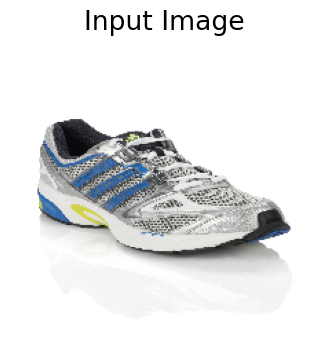

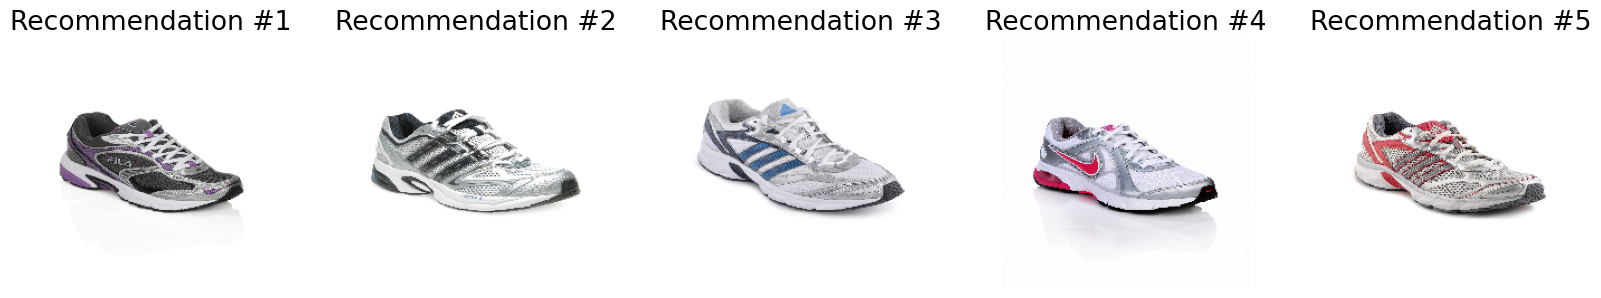

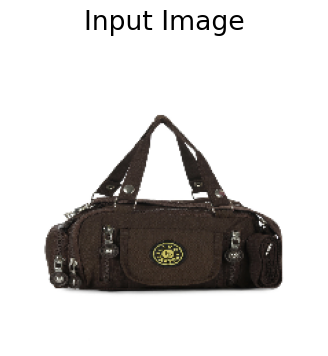

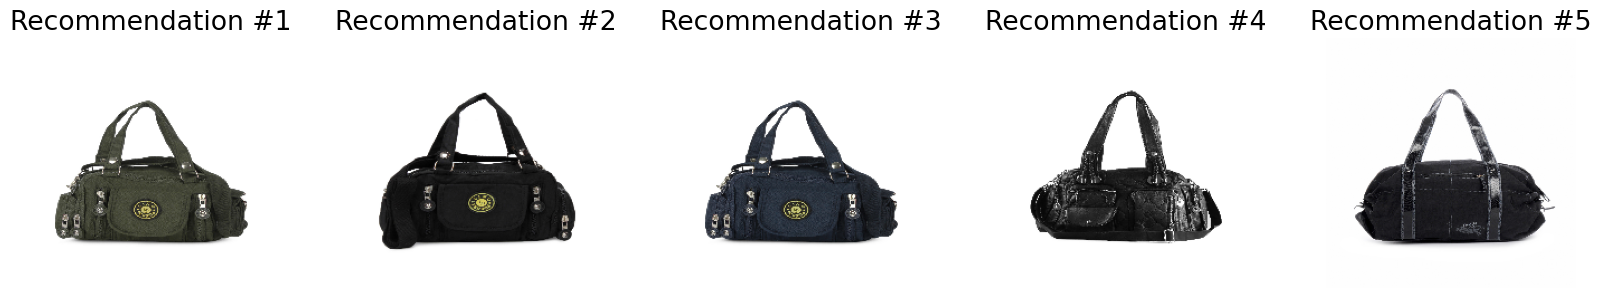

In [26]:
# Display recommendations for a couple of random images
for _ in range(2):
    i = random.randint(0,len(styles_df))
    img1 = read_img(styles_df.loc[i,'filename'])
    dist, index = nearest_neighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')
   
    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles_df.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Recommendation #{i}')
        plt.axis('off')

In [32]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN model on training set
nearest_neighbors.fit(X_train, y_train)

# Make predictions on test set
y_pred = nearest_neighbors.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0
